# Proyecto Final - Applied Deep Learning Class
-------------------
Mario Garcia - Mónica Gutierrez


In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
%matplotlib inline

# Read Data

In [2]:
path = 'C:/Users/admicf/Documents/AppliedDeepLearningClass-master/exercises/ProyectoFinal/'

In [3]:
dataTraining = pd.read_csv(os.path.join(path, 'dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path, 'dataTesting.csv'), encoding='UTF-8', index_col=0)
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [4]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Read Images

In [6]:
images_training = []
for i in tqdm(dataTraining.index):
    images_training.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')))

100%|████████████████████████████████████████████████████| 7895/7895 [00:09<00:00, 843.23it/s]


In [7]:
images_training = np.stack(images_training)
images_training.shape, dataTraining.shape[0]

((7895, 256, 160), 7895)

In [8]:
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')))

100%|████████████████████████████████████████████████████| 3383/3383 [00:03<00:00, 854.10it/s]


In [9]:
images_testing = np.stack(images_testing)
images_testing.shape, dataTesting.shape[0]

((3383, 256, 160), 3383)

# Create y

In [10]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [11]:
y_genres.shape

(7895, 24)

In [12]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training, y_genres, test_size=0.20, random_state=666)

In [13]:
X_train.shape, y_train_genres.shape

((6316, 256, 160), (6316, 24))

# Simple NN (1 dense layer) 

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from livelossplot import PlotLossesKeras

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model_rn1 = Sequential()
model_rn1.add(Flatten(input_shape = (256, 160)))
model_rn1.add(Dense(units=24))
model_rn1.add(Activation('sigmoid'))
model_rn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 40960)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                983064    
_________________________________________________________________
activation_1 (Activation)    (None, 24)                0         
Total params: 983,064
Trainable params: 983,064
Non-trainable params: 0
_________________________________________________________________


In [16]:
from keras.optimizers import RMSprop

model_rn1.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
              metrics = ['accuracy'])
model_rn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 40960)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                983064    
_________________________________________________________________
activation_1 (Activation)    (None, 24)                0         
Total params: 983,064
Trainable params: 983,064
Non-trainable params: 0
_________________________________________________________________


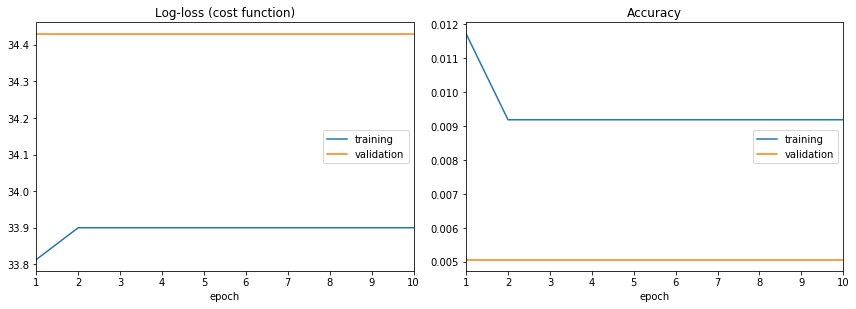

In [17]:
batch_size = 32
epochs = 10
history = model_rn1.fit(X_train, y_train_genres, validation_data=[X_test, y_test_genres],
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[PlotLossesKeras()])

In [18]:
y_pred_genres = model_rn1.predict_proba(X_test)
y_test_genres.shape, y_pred_genres.shape

((1579, 24), (1579, 24))

In [61]:
roc_auc_score(y_test_genres, y_pred_genres, average= 'micro')

0.7928370756277691

In [20]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model_rn1.predict_proba(images_testing)

In [21]:
pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RN1.csv', index_label='ID')

## Simple CNN 

In [22]:
X_train_2=X_train.reshape(6316,256, 160,1)
X_test_2=X_test.reshape(1579,256, 160,1)

In [23]:
from keras.layers import Dropout

model_r2 = Sequential()
model_r2.add(Conv2D(32, (3, 3), padding='same', 
          input_shape=(256, 160, 1)))
model_r2.add(Activation('relu'))
model_r2.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))
model_r2.add(Dropout(0.2, noise_shape=None, seed=None))
model_r2.add(Flatten())
model_r2.add(Dense(units=24))
model_r2.add(Activation('sigmoid'))
model_r2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 160, 32)      320       
_________________________________________________________________
activation_2 (Activation)    (None, 256, 160, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 80, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 80, 32)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 327680)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                7864344   
_________________________________________________________________
activation_3 (Activation)    (None, 24)                0         
Total para

In [24]:
from keras.optimizers import SGD, RMSprop
model_r2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
              metrics=['accuracy'])
model_r2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 160, 32)      320       
_________________________________________________________________
activation_2 (Activation)    (None, 256, 160, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 80, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 80, 32)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 327680)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                7864344   
_________________________________________________________________
activation_3 (Activation)    (None, 24)                0         
Total para

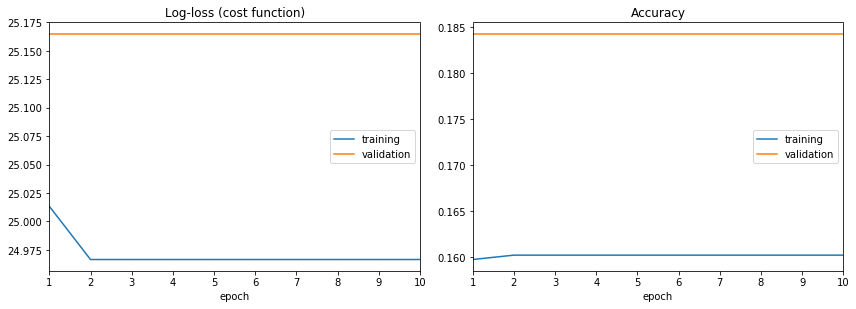

In [25]:
batch_size = 32
epochs = 10
history = model_r2.fit(X_train_2, y_train_genres, validation_data=[X_test_2, y_test_genres],
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[PlotLossesKeras()])

In [ ]:
y_pred_genres = model_r2.predict(X_test_2)

In [60]:
roc_auc_score(y_test_genres, y_pred_genres, average= 'micro')

0.7928370756277691

In [27]:
images_testing_2 = images_testing.reshape(3383, 256, 160,1)

In [28]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model_r2.predict_proba(images_testing_2)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RN2.csv', index_label='ID')

# Transfer Learning

In [ ]:
from keras.applications.vgg16 import VGG16
model_vgg16 = VGG16(weights='imagenet', include_top=False)

In [ ]:
X_train_2 = model_vgg16.predict(X_train_2)

In [ ]:
X_test_2 = model_vgg16.predict(X_test)

In [67]:
model_r3 = Sequential()

model_r3.add(Flatten(input_shape=(6,6,512)))
model_r3.add(Dense(units=512))
model_r3.add(Activation('relu'))
model_r3.add(Dropout(0.3, noise_shape=None, seed=None))
model_r3.add(Dense(units=24))
model_r3.add(Activation('sigmoid'))
model_r3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               9437696   
_________________________________________________________________
activation_18 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 24)                12312     
_________________________________________________________________
activation_19 (Activation)   (None, 24)                0         
Total params: 9,450,008
Trainable params: 9,450,008
Non-trainable params: 0
_________________________________________________________________


In [68]:
model_r3.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
              metrics=['accuracy'])
model_r3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               9437696   
_________________________________________________________________
activation_18 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 24)                12312     
_________________________________________________________________
activation_19 (Activation)   (None, 24)                0         
Total params: 9,450,008
Trainable params: 9,450,008
Non-trainable params: 0
_________________________________________________________________


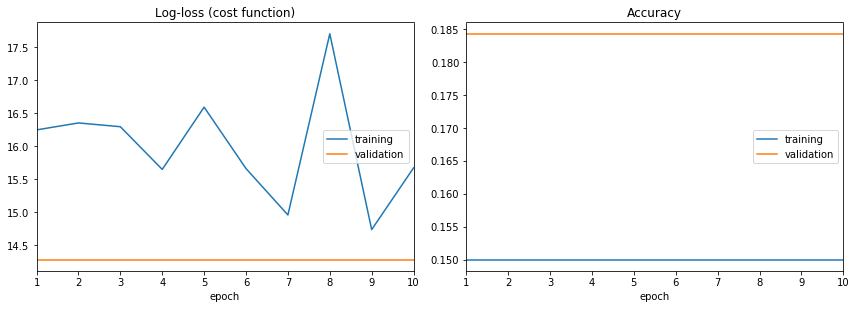

In [79]:
batch_size = 32
epochs = 10
history = model_r3.fit(X_train_2, y_train_genres, validation_data=[X_test_2, y_test_genres],
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[PlotLossesKeras()])

# CNN Final

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.layers.normalization import BatchNormalization
import glob
import csv

from numpy import array, asarray, ndarray
#training controls
batch_size = 25
epochs = 5
training_size = 0.75

# input image dimensions
img_rows, img_cols = 256, 160

#defining the model
model_rn3 = Sequential()
#input
model_rn3.add(Conv2D(128,data_format = 'channels_last', kernel_size=(3, 3),
                 input_shape=(img_rows, img_cols,1)))
model_rn3.add(Activation('relu'))
model_rn3.add(Dropout(0.3))
#convolutions

model_rn3.add(Conv2D(64, (3, 3)))
model_rn3.add(Activation('relu'))
model_rn3.add(MaxPooling2D(pool_size=(3, 3)))
model_rn3.add(Dropout(0.3))

model_rn3.add(Conv2D(64, (2,2)))
model_rn3.add(Activation('relu'))
model_rn3.add(MaxPooling2D(pool_size=(2,2)))
model_rn3.add(Dropout(0.3))

model_rn3.add(Conv2D(64, (2,2)))
model_rn3.add(Activation('relu'))
model_rn3.add(MaxPooling2D(pool_size=(2,2)))
model_rn3.add(Dropout(0.2))

model_rn3.add(Conv2D(64, (2,2)))
model_rn3.add(Activation('relu'))
model_rn3.add(MaxPooling2D(pool_size=(2,2)))
model_rn3.add(Dropout(0.2))

model_rn3.add(Conv2D(64, (2,2)))
model_rn3.add(Activation('relu'))
model_rn3.add(MaxPooling2D(pool_size=(2,2)))
model_rn3.add(Dropout(0.2))

model_rn3.add(Conv2D(32, (2,2)))
model_rn3.add(Activation('relu'))
model_rn3.add(Dropout(0.2))

#dense layers
model_rn3.add(Flatten())

model_rn3.add(Dense(16))
model_rn3.add(Activation('relu'))
model_rn3.add(Dropout(0.15))

model_rn3.add(Dense(16))
model_rn3.add(Activation('relu'))
model_rn3.add(Dropout(0.15))

model_rn3.add(Dense(8))
model_rn3.add(Activation('relu'))
model_rn3.add(Dropout(0.15))

#output
model_rn3.add(Dense(24))

#printing model summary
print(model_rn3.summary())

#compiling the model
model_rn3.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 158, 128)     1280      
_________________________________________________________________
activation_14 (Activation)   (None, 254, 158, 128)     0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 254, 158, 128)     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 252, 156, 64)      73792     
_________________________________________________________________
activation_15 (Activation)   (None, 252, 156, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 84, 52, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 84, 52, 64)        0         
__________

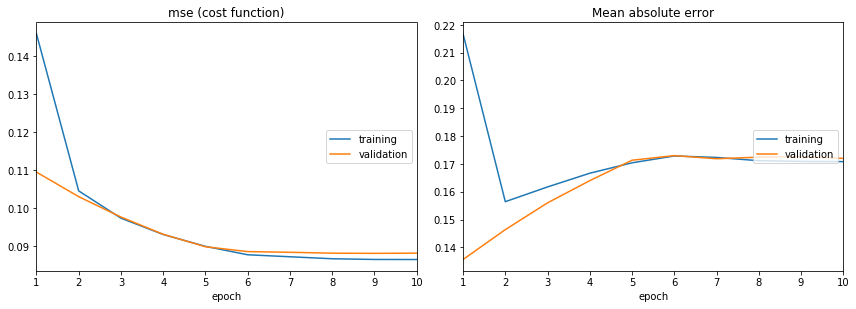

16766.7411839962


In [42]:
#training the model
import time
time0 = time.time()
batch_size = 32
epochs = 10
model_rn3.fit(X_train_2[:1500], y_train_genres[:1500], validation_data=[X_test_2[:500], y_test_genres[:500]],
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[PlotLossesKeras()])
time1= time.time()
print(time1-time0)

In [44]:
model_rn3.save('model_rn3_2.h5')
#model = load_model('model_rn1.h5')

In [45]:
y_pred_genres = model_rn3.predict_proba(X_test_2)
y_test_genres.shape, y_pred_genres.shape

((1579, 24), (1579, 24))

In [59]:
roc_auc_score(y_test_genres, y_pred_genres, average= 'micro')

0.7928370756277691

In [48]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model_rn3.predict_proba(images_testing_2)

In [49]:
pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_RN_3.csv', index_label='ID')